In [6]:
import pandas as pd
import os
import glob

# =========================
# FOLDER PATH
# =========================
input_folder = "fundamental_data"      # folder containing raw CSVs
output_folder = "clean_fundamental_data"

# Create output folder if not exists
os.makedirs(output_folder, exist_ok=True)

# =========================
# INDICATORS TO KEEP
# =========================
relevant_indicators = [
    "Net Sales/Income from operations",
    "Total Income From Operations",
    "Net Profit/(Loss) For the Period",
    "P/L Before Tax",
    "Interest",
    "Depreciation",
    "Basic EPS",
    "Equity Share Capital"
]

# =========================
# PROCESS ALL CSV FILES
# =========================
files = glob.glob(os.path.join(input_folder, "*.csv"))

for input_file in files:

    print("Processing:", input_file)

    df = pd.read_csv(input_file)

    # Clean column names
    df.columns = df.columns.str.strip()

    # Filter relevant rows
    filtered = df[df["Indicators"].isin(relevant_indicators)]

    # Transpose
    filtered.set_index("Indicators", inplace=True)
    clean_df = filtered.T

    # Reset index
    clean_df.reset_index(inplace=True)
    clean_df.rename(columns={"index": "Quarter"}, inplace=True)

    # =========================
    # OUTPUT FILE NAME
    # =========================
    filename = os.path.basename(input_file)
    output_file = os.path.join(output_folder, filename.replace(".csv", "_clean.csv"))

    clean_df.to_csv(output_file, index=False)

    print("✅ Saved:", output_file)

print("\n🎉 All files processed successfully!")


Processing: fundamental_data\reliance_fundamentals.csv
✅ Saved: clean_fundamental_data\reliance_fundamentals_clean.csv

🎉 All files processed successfully!


In [12]:
import yfinance as yf
import pandas as pd
import os

# =========================
# STOCK LIST
# =========================
stocks = {
    "RELIANCE": "RELIANCE.NS",
    "HDFCBANK": "HDFCBANK.NS",
    "INFY": "INFY.NS",
    "M&M": "M&M.NS",
    "BHARTIARTL": "BHARTIARTL.NS",
    "HUL": "HINDUNILVR.NS"
}

start_date = "2020-01-01"
end_date = "2026-01-01"

os.makedirs("market_data/train", exist_ok=True)
os.makedirs("market_data/test", exist_ok=True)

# =========================
# LOOP THROUGH STOCKS
# =========================
for name, ticker in stocks.items():

    print(f"\nDownloading {name}...")

    data = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        auto_adjust=False
    )

    data.reset_index(inplace=True)

    # Split
    train = data[data["Date"] < "2025-10-01"]
    test = data[data["Date"] >= "2025-10-01"]

    # Save
    train.to_csv(f"market_data/train/{name}_train.csv", index=False)
    test.to_csv(f"market_data/test/{name}_test.csv", index=False)

    print(f"✅ Saved {name}")

print("\n🎉 All market data downloaded!")


[*********************100%***********************]  1 of 1 completed


✅ Saved RELIANCE



[*********************100%***********************]  1 of 1 completed


✅ Saved HDFCBANK



[*********************100%***********************]  1 of 1 completed


✅ Saved INFY



[*********************100%***********************]  1 of 1 completed


✅ Saved M&M



[*********************100%***********************]  1 of 1 completed


✅ Saved BHARTIARTL



[*********************100%***********************]  1 of 1 completed

✅ Saved HUL

🎉 All market data downloaded!


,date,adj close,close,high,low,open,volume
0,2020-01-01,605.529358,639.299988,640.0,635.299988,638.049988,3673698
1,2020-01-02,609.38916,643.375000,644.0,639.5,639.5,6137166
2,2020-01-03,600.698792,634.200012,642.5,631.799988,641.099976,10855550
3,2020-01-06,587.698792,620.474976,630.900024,618.0,630.0,10890186
4,2020-01-07,597.004822,630.299988,635.724976,626.125,629.450012,14724494


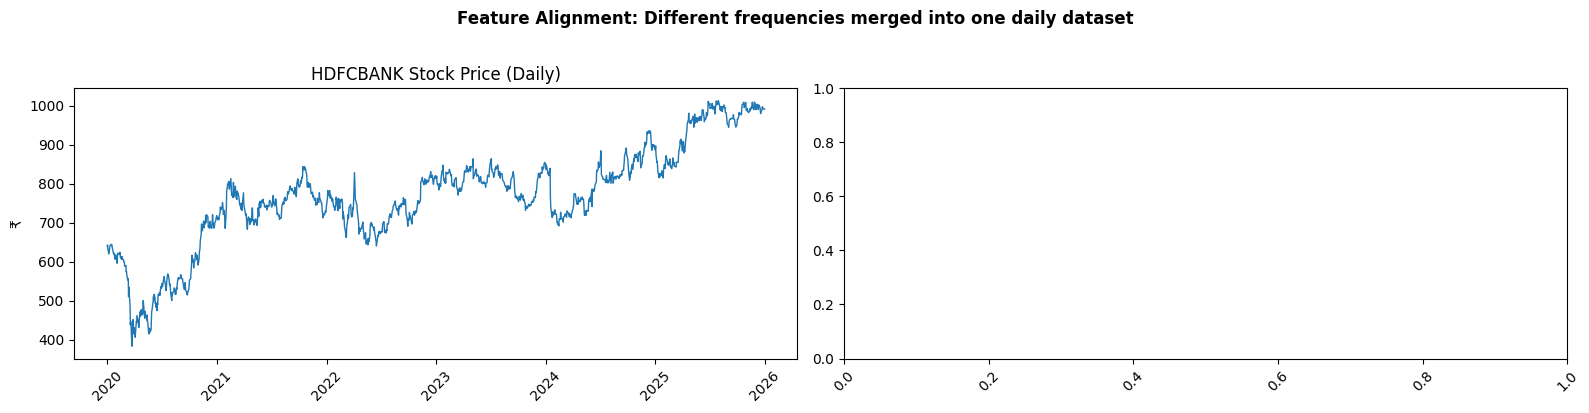

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# ============================================================
# 1. LOAD AND PREPARE DATA
# ============================================================
name = "HDFCBANK"

train_path = f"market_data/train/{name}_train.csv"
test_path = f"market_data/test/{name}_test.csv"

if os.path.exists(train_path) and os.path.exists(test_path):
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    df = pd.concat([df_train, df_test], ignore_index=True)
else:
    print("Files not found! Please run your download script first.")
    raise SystemExit

# ------------------------------------------------------------
# CLEANING
# ------------------------------------------------------------

# Make column names lowercase
df.columns = [c.lower() for c in df.columns]

# Remove accidental ticker rows
df = df[df['close'] != 'HDFCBANK.NS']

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convert price column to numeric
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Drop bad rows
df = df.dropna(subset=['date', 'close'])

# VERY IMPORTANT: sort by date
df = df.sort_values('date')

# Reset index (optional but clean)
df = df.reset_index(drop=True)

display(df.head())

# ============================================================
# 2. PLOTTING
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Main stock price plot
axes[0].plot(df['date'], df['close'], linewidth=1)
axes[0].set_title('HDFCBANK Stock Price (Daily)')
axes[0].set_ylabel('₹')

# Nice date formatting
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate ticks
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.suptitle(
    'Feature Alignment: Different frequencies merged into one daily dataset',
    fontsize=12,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()
